In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

import pandas as pd
import numpy as np
import vset, bounds
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

from dgp import *
import estimation, utils, experiments, plots, realdata

In [19]:
df = pd.read_csv('data/obermeyer.csv')
screen_in = df[df['program_enrolled_t'] == 1]
screen_out = df[df['program_enrolled_t'] == 0].iloc[:2000]
df = pd.concat([screen_in, screen_out])

feats = [i for i in df.columns.tolist() if 'tm1' in i]

feats





['dem_age_band_18-24_tm1',
 'dem_age_band_25-34_tm1',
 'dem_age_band_35-44_tm1',
 'dem_age_band_45-54_tm1',
 'dem_age_band_55-64_tm1',
 'dem_age_band_65-74_tm1',
 'dem_age_band_75+_tm1',
 'alcohol_elixhauser_tm1',
 'anemia_elixhauser_tm1',
 'arrhythmia_elixhauser_tm1',
 'arthritis_elixhauser_tm1',
 'bloodlossanemia_elixhauser_tm1',
 'coagulopathy_elixhauser_tm1',
 'compdiabetes_elixhauser_tm1',
 'depression_elixhauser_tm1',
 'drugabuse_elixhauser_tm1',
 'electrolytes_elixhauser_tm1',
 'hypertension_elixhauser_tm1',
 'hypothyroid_elixhauser_tm1',
 'liver_elixhauser_tm1',
 'neurodegen_elixhauser_tm1',
 'obesity_elixhauser_tm1',
 'paralysis_elixhauser_tm1',
 'psychosis_elixhauser_tm1',
 'pulmcirc_elixhauser_tm1',
 'pvd_elixhauser_tm1',
 'renal_elixhauser_tm1',
 'uncompdiabetes_elixhauser_tm1',
 'valvulardz_elixhauser_tm1',
 'wtloss_elixhauser_tm1',
 'cerebrovasculardz_romano_tm1',
 'chf_romano_tm1',
 'dementia_romano_tm1',
 'hemiplegia_romano_tm1',
 'hivaids_romano_tm1',
 'metastatic_roma

In [7]:
df = pd.read_csv('data/obermeyer.csv')
n_screen_out = 2000

screen_in = df[df['program_enrolled_t'] == 1]
screen_out = df[df['program_enrolled_t'] == 0].iloc[:n_screen_out]
df = pd.concat([screen_in, screen_out]).sample(frac=1).reset_index(drop=True)

# Calculate the number of samples for the training set (40% of the total)
train_size = int(len(df) * 0.4)

# Split the data into training and testing sets
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [28]:
def get_screening_dgp(fname, n_screen_out):

    # Load dataset
    df = pd.read_csv(fname)
    screen_in = df[df['program_enrolled_t'] == 1]
    screen_out = df[df['program_enrolled_t'] == 0].iloc[:n_screen_out]
    df = pd.concat([screen_in, screen_out]).sample(frac=1).reset_index(drop=True)
    feats = [i for i in df.columns.tolist() if 'tm1' in i]
    
    # Calculate the number of samples for the training set (40% of the total)
    train_size = int(len(df) * 0.2)

    # Split the data into training and testing sets
    train_df, df = df.iloc[:train_size], df.iloc[train_size:]
    model, scaler = LinearRegression(), StandardScaler()
    df_scaled = scaler.fit_transform(train_df[feats])
    model.fit(df_scaled, train_df['cost_t'])
    test_feats = scaler.transform(df[feats])
    
    # Set up an auditing sample on the remaining dataset
    data = {}
    feats = ['gagne_sum_tm1', 'renal_elixhauser_tm1', 'alcohol_elixhauser_tm1', 'hypertension_elixhauser_tm1',
             'dem_age_band_18-24_tm1', 'dem_age_band_25-34_tm1', 'dem_age_band_35-44_tm1', 'dem_age_band_45-54_tm1',
             'dem_age_band_55-64_tm1', 'dem_age_band_65-74_tm1', 'dem_age_band_75+_tm1']
    data['T'] = (model.predict(test_feats) > 6000).astype(int)
    data['Y'] = (df['gagne_sum_t'] > 0).astype(int).to_numpy()
    data['D'] = df['program_enrolled_t'].to_numpy()
    data['XU'] = df[feats].to_numpy()
    data['Z'] = np.ones_like(df['cost_t'])
    
    # Save demographic variables in the dataset
    df['65p'] = ((df['dem_age_band_65-74_tm1'] == 1) | (df['dem_age_band_75+_tm1'] == 1)).astype(int)
    
    for race in df['race'].unique():
        for age in df['65p'].unique():
            age_desc = '65+' if age==1 else '<65'
            data[f'x_{race}_{age_desc}'] = ((df['race'] == race) & (df['65p'] == age)).astype(int).to_numpy()
    
    return data

/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


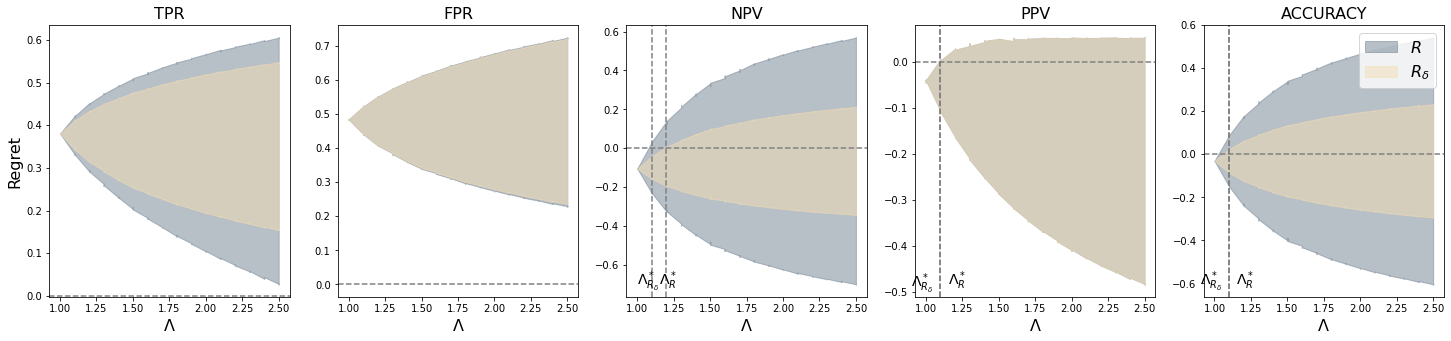

In [29]:
data = get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=3000)

dgp = {
    'N': 10000,
    'Dx': data['XU'].shape[1],
    'Du': 0,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'lambda': 2
}

lambdas = np.arange(1, 2.6, .1)
data = get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=3000)
estimation.sample_split_crossfit(dgp, data, id_method='MSM', est_method='plugin', K=5)
brdf = experiments.design_sensitivity_exp(dgp, data, lambdas, n_sims=10)
plots.plot_design_sensitivity(brdf)


## Utility ratio curve

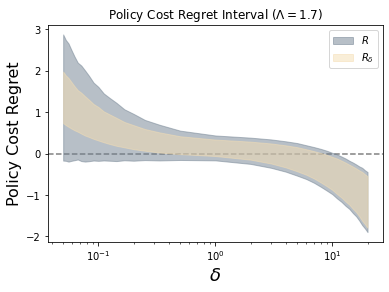

In [38]:
Dx, Du = 5, 0
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': data['XU'].shape[1],
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 2
}
dgp = set_dgp_config(dgp, 'MSM')
data = get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=3000)
crdf = experiments.cost_ratio_sweep_exp(dgp, data, lam=1.7)
plots.plot_cost_ratio_curve(dgp, crdf)



## Evaluating the subgroup regret

In [31]:
Dx, Du = 5, 0
nD = Dx+Du

dgp = {
    'Dx': data['XU'].shape[1],
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.2
}

In [32]:

n_sims = 20
K=2

bound_lists = []

data = get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=2000)
groups = [c for c in data.keys() if 'x_' in c]

for s in range(n_sims):

    u = np.array([[1,0], [0, 1]])
    dgp = set_dgp_config(dgp, 'MSM')
    
    for k in range(K):
        
        in_folds, out_folds = utils.k_fold_split_and_complement(data.copy(), K)

        # Set-up datasets for fold K
        in_data, out_data = in_folds[k], out_folds[k]
        in_dgp, out_dgp = dgp.copy(), dgp.copy()
        in_dgp['N'] = in_data['XU'].shape[0]
        out_dgp['N'] = out_data['XU'].shape[0]

        # Learn models, then run inference via data from fold k
        in_probs = estimation.plugin_nuisance_probs(in_dgp, out_dgp, in_data, out_data)
        
        # First add the population regret
        Vpf_down, Vpf_up = vset.get_vset(in_dgp, in_data, in_probs, id_method='MSM')
        bdf = bounds.get_bounds(in_data, Vpf_down, Vpf_up, u, verbose=False)
        bdf['g'] = '_Population'
        bdf['s'] = s
        bdf['selection_rate'] = in_data['D'].mean()
        bdf['size'] = 1
        bound_lists.append(bdf)

        # Add subgroup-level regret
        for g in groups: 
            gdata = utils.mask_dictionary_arrays(in_data.copy(), in_data[g])
            gprobs = utils.mask_dictionary_arrays(in_probs.copy(), in_data[g])

            # After learning the nuisance functions, we need to evaluate this over each subgroup
            Vpf_down, Vpf_up = vset.get_vset(in_dgp, gdata, gprobs, id_method='MSM')
            bdf = bounds.get_bounds(gdata, Vpf_down, Vpf_up, u, verbose=False)
            bdf['g'] = g
            bdf['s'] = s
            bdf['selection_rate'] = gdata['D'].mean()
            bdf['size'] = gdata['XU'].shape[0] / in_data['XU'].shape[0]
            bound_lists.append(bdf)
            
group_bounds = pd.concat(bound_lists).groupby(['g', 's', 'metric']).mean().reset_index()

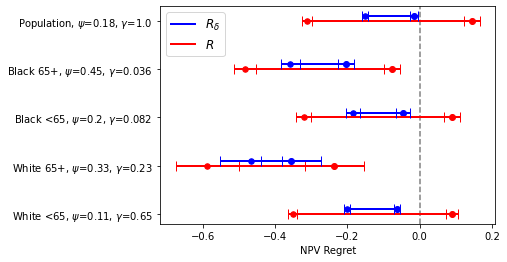

In [33]:
metric = 'm_a=0'

mdf = group_bounds[group_bounds['metric'] == metric].reset_index(drop=True)
groups = mdf['g'].to_list()

plt.axvline(0, color='grey', zorder=1, linestyle='--')
gdfm = mdf.groupby(['g']).mean().reset_index()[::-1]

for ix, row in gdfm.iterrows():
    
    gdf = mdf[mdf['g'] == row['g']]
    
    plt.plot([row['Rs_down'], row['Rs_up']], [ix, ix], color='r', label="Rs", linewidth=2)
    plt.plot([row['Rd_down'], row['Rd_up']], [ix+.1, ix+.1], color='b', label="Rd", linewidth=2)
    
    plt.scatter(row['Rs_down'], ix,  color='r', s=30)
    plt.scatter(row['Rs_up'], ix, color='r', label="R")
    
    plt.scatter(row['Rd_down'], ix+.1,  color='b', s=30)
    plt.scatter(row['Rd_up'], ix+.1, color='b', label="R")
    
    sd = gdf['Rs_down'].tolist()
    ci_d = sms.DescrStatsW(sd).tconfint_mean()
    l_d = abs(ci_d[1]-ci_d[0])
    plt.errorbar(row['Rs_down'], ix, xerr=l_d, color='r', fmt='none', capsize=5, linewidth=2, elinewidth=2)

    
    sd = gdf['Rs_up'].tolist()
    ci_d = sms.DescrStatsW(sd).tconfint_mean()
    l_d = abs(ci_d[1]-ci_d[0])
    plt.errorbar(row['Rs_up'], ix, xerr=l_d, color='r', fmt='none', capsize=5, linewidth=2, elinewidth=2)

    
    sd = gdf['Rd_down'].tolist()
    ci_d = sms.DescrStatsW(sd).tconfint_mean()
    l_d = abs(ci_d[1]-ci_d[0])
    plt.errorbar(row['Rd_down'], ix+.1, xerr=l_d, color='b', fmt='none', capsize=5, linewidth=2, elinewidth=2)

    
    sd = gdf['Rd_up'].tolist()
    ci_d = sms.DescrStatsW(sd).tconfint_mean()
    l_d = abs(ci_d[1]-ci_d[0])
    plt.errorbar(row['Rd_up'], ix+.1, xerr=l_d, color='b', fmt='none', capsize=5, linewidth=2, elinewidth=2)




keys = [i for i in range(gdfm.shape[0])]
vals = realdata.get_group_descs(gdfm)
plt.yticks(keys, vals)

plt.xlabel(f'{utils.metric_dict[metric]} Regret')

# Create a custom legend
custom_legend = [
    plt.Line2D([0], [0], color='b', lw=2, label='$R_{\delta}$', linestyle='-'),
    plt.Line2D([0], [0], color='r', lw=2, label='$R$', linestyle='-'),
]

lgd = plt.legend(handles=custom_legend,  fontsize=12, loc='upper left')
